In [1]:
# ✅ 셀 1: 패키지 및 설정
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
import pandas as pd
import time
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 크롬 설정
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

service = Service('C:/Users/User/.wdm/drivers/chromedriver/win64/136.0.7103.94/chromedriver-win32/chromedriver.exe')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 중복 방지 경로 생성 함수
def unique_path(path):
    if not os.path.exists(path):
        return path
    base, ext = os.path.splitext(path)
    i = 1
    while os.path.exists(f"{base}({i}){ext}"):
        i += 1
    return f"{base}({i}){ext}"

# 저장 경로 설정
today_str = datetime.today().strftime('%Y-%m-%d')
folder_path = unique_path(os.path.join('data', today_str))
os.makedirs(folder_path, exist_ok=True)
merged_file_path = unique_path(os.path.join(folder_path, f"{today_str}_전체_리뷰통합.csv"))

# 감성 키워드
pos_words = ['좋다','재밌다','감동','최고','웃기다','재밌었어요','흥미진진','꿀잼','완전 재밌음','감명', '귀엽', '참 잘', '미쳤다', '따뜻',
            '울컥', '신남', '신나고', '정말 좋', '잼있', '현실감 있', '너무 좋', '퀄리티 미쳤', '미쳤어요', '미침', '좋아하네요', '좋아요', '좋음',
            '예뻐', '제일 잘', '또 봐야지', '힐링', '놀람', '추천', '케미', '재밌', '최고', '여운', '좋았습니다', '재밌어요', '좋았어요',
            '응원', '신선', '제일 괜찮', '다음 기대', '잘 표현', '또 봐야', '잘 봤', '기대되', '즐거운']
             
neg_words = ['지루', '별로', '최악', '실망', '노잼', '지루했어요', '망작', '형편없다', '재미없음','진부', '좀.', '개빡', '볼만', '아닌듯', '불편',
             '딱히', '그닥', '비추', '흥미없', '재미없어요', '재미없다', '쓰레기', '아깝다', '최악', '유발', '졸림', '애매']

def analyze_sentiment(text):
    text = str(text).lower()
    pos = sum(w in text for w in pos_words)
    neg = sum(w in text for w in neg_words)
    if pos > neg:
        return '긍정'
    elif neg > pos:
        return '부정'
    else:
        return '중립'

In [2]:
# ✅ 셀 2: 리뷰 수집 함수 정의
def get_all_reviews(url):
    driver = webdriver.Chrome(service=service, options=chrome_options)
    driver.get(url)
    time.sleep(1)

    writers, reviews, dates = [], [], []

    while True:
        try:
            writers += [w.text for w in driver.find_elements('class name', 'writer-name')]
            reviews += [r.text for r in driver.find_elements('class name', 'box-comment')]
            dates += [d.text for d in driver.find_elements('class name', 'day')]

            next_button = driver.find_element('class name', 'btn-paging.next')
            next_button.click()
            time.sleep(0.5)
        except:
            break

    driver.quit()

    df = pd.DataFrame({'날짜': dates, '작성자': writers, '리뷰내용': reviews})
    df['감성'] = df['리뷰내용'].apply(analyze_sentiment)
    return df

In [5]:
# ✅ 셀 3: 메인 크롤링 및 저장 루프
driver = webdriver.Chrome(service=service, options=chrome_options)
driver.get('http://www.cgv.co.kr/movies/')
time.sleep(1)

# 더보기 버튼 반복 클릭
while True:
    try:
        more = driver.find_element('class name', 'btn-more-fontbold')
        driver.execute_script("arguments[0].click();", more)
        time.sleep(1)
    except:
        break

# 영화 요소 수집
movie_chart = driver.find_element('class name', 'sect-movie-chart')
contents = movie_chart.find_elements('class name', 'box-contents')

all_reviews = []
summary_data = []

for content in contents:
    try:
        title = content.find_element('class name', 'title').text
        url = content.find_element('tag name', 'a').get_attribute('href')

        print(f"\n🎬 수집 중: {title}")
        df = get_all_reviews(url)
        if df.empty:
            print("(리뷰 없음) 건너뜀")
            continue

        safe_title = ''.join(c for c in title if c.isalnum() or c.isspace()).strip()
        csv_path = unique_path(os.path.join(folder_path, f"{safe_title}_리뷰.csv"))
        df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"✅ 저장 완료: {csv_path} ({len(df)}개)")

        df['영화제목'] = title
        all_reviews.append(df)

        # 감성 시각화 - 파이
        counts = df['감성'].value_counts()
        counts.plot(kind='pie', autopct='%.1f%%', ylabel='', title=f'{title} 리뷰 감성 분포')
        plt.savefig(unique_path(os.path.join(folder_path, f"{safe_title}_감성분포.png")))
        plt.clf()

        # 요약용 정보 저장
        summary_data.append({
            '영화제목': title,
            '리뷰수': len(df),
            '긍정': (df['감성'] == '긍정').sum(),
            '부정': (df['감성'] == '부정').sum(),
            '중립': (df['감성'] == '중립').sum()
        })

    except Exception as e:
        print(f"⚠️ 오류 발생: {e}")
        continue


🎬 수집 중: 미션 임파서블: 파이널 레코닝
✅ 저장 완료: data\2025-05-27(1)\미션 임파서블 파이널 레코닝_리뷰.csv (1584개)

🎬 수집 중: 릴로 & 스티치
✅ 저장 완료: data\2025-05-27(1)\릴로  스티치_리뷰.csv (294개)

🎬 수집 중: 나를 모르는 그녀의 세계에서
✅ 저장 완료: data\2025-05-27(1)\나를 모르는 그녀의 세계에서_리뷰.csv (204개)

🎬 수집 중: 야당
✅ 저장 완료: data\2025-05-27(1)\야당_리뷰.csv (1884개)

🎬 수집 중: 파과
✅ 저장 완료: data\2025-05-27(1)\파과_리뷰.csv (1074개)

🎬 수집 중: 해피엔드
✅ 저장 완료: data\2025-05-27(1)\해피엔드_리뷰.csv (264개)

🎬 수집 중: 걸어도 걸어도
✅ 저장 완료: data\2025-05-27(1)\걸어도 걸어도_리뷰.csv (108개)

🎬 수집 중: 파이널 데스티네이션 블러드라인
✅ 저장 완료: data\2025-05-27(1)\파이널 데스티네이션 블러드라인_리뷰.csv (192개)

🎬 수집 중: 몽상가의 나흘 밤
✅ 저장 완료: data\2025-05-27(1)\몽상가의 나흘 밤_리뷰.csv (30개)

🎬 수집 중: 썬더볼츠
✅ 저장 완료: data\2025-05-27(1)\썬더볼츠_리뷰.csv (1536개)

🎬 수집 중: 슈가 글라스 보틀
✅ 저장 완료: data\2025-05-27(1)\슈가 글라스 보틀_리뷰.csv (108개)

🎬 수집 중: 부정선거, 신의 작품인가
✅ 저장 완료: data\2025-05-27(1)\부정선거 신의 작품인가_리뷰.csv (18개)

🎬 수집 중: 아멜리에
✅ 저장 완료: data\2025-05-27(1)\아멜리에_리뷰.csv (174개)

🎬 수집 중: A MINECRAFT MOVIE 마인크래프트 무비
✅ 저장 완료: data\2025-05-27(1)\A MINECRAFT MOVIE 마인크래프트 무비_리

<Figure size 640x480 with 0 Axes>


📦 전체 통합 리뷰 저장 완료: data\2025-05-27(1)\2025-05-27_전체_리뷰통합.csv (9689개)


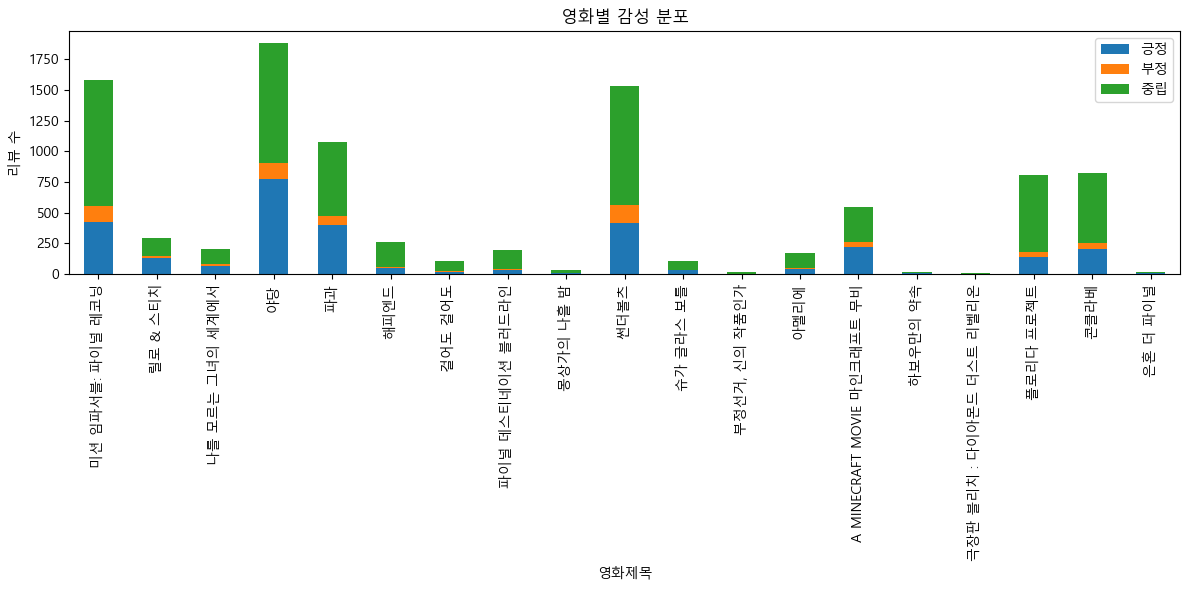

In [6]:
# ✅ 셀 4: 전체 리뷰 통합 저장 및 막대그래프
if all_reviews:
    merged_df = pd.concat(all_reviews, ignore_index=True)
    merged_df.to_csv(merged_file_path, index=False, encoding='utf-8-sig')
    print(f"\n📦 전체 통합 리뷰 저장 완료: {merged_file_path} ({len(merged_df)}개)")

    # 요약 데이터프레임 생성 및 시각화
    summary_df = pd.DataFrame(summary_data)
    summary_df.set_index('영화제목')[['긍정', '부정', '중립']].plot(kind='bar', stacked=True, figsize=(12,6), title='영화별 감성 분포')
    plt.ylabel('리뷰 수')
    plt.tight_layout()
    plt.savefig(unique_path(os.path.join(folder_path, "영화별_감성_막대그래프.png")))
    plt.show()
else:
    print("❌ 수집된 리뷰가 없습니다.")